# Sampling frequency of the data

In [1]:
import torch
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import random
import h5py
import sys
sys.path.append('D:\RU\OneDrive\Intern\Master\data')
sys.path.append('D:\RU\OneDrive\Intern\Master\RBMs\Codes')

#from loaddata import load_data
from manipulate_data import *
from RTRBM_batches import RTRBM
from plots import *
from loaddata import load_data
from funcs import *

### Generate surrogate data and train an RTRBM

In [2]:
data_obj = h5py.File('D:\TUe\OneDrive - TU Eindhoven\RU\Boltzmann/subject_1_reconv_spikes.h5', 'r')
behavior = data_obj['Data']['behavior']
coords = data_obj['Data']['coords']
df = np.transpose(data_obj['Data']['df'])
spikes = torch.tensor((data_obj['Data']['spikes']))
stimulus = data_obj['Data']['stimulus']

D:\RU\OneDrive\Intern\Master\data\manipulate_data.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  firing_probability = torch.tensor(average_firing_rate * (signal.sawtooth(2 * np.pi * stimulus_frequency * time_arr, 0.5) + 1))
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


Text(0, 0.5, 'RMS error')

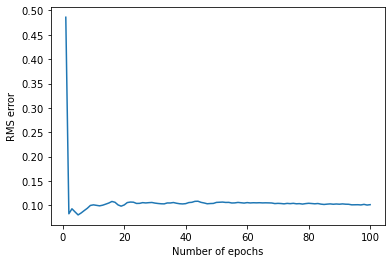

In [3]:
# number of visible and hidden nodes, and timesteps
N_V = 128
N_H = 32
T = 2000
n_batches = 256

# generate mock data with time dependent firing in batches
#data = torch.zeros([N_V, T, n_batches])
#for i in range(n_batches):
#    data[:,:,i] = generate_data_fr_dist(N_V, T, spikes_true = spikes, true_sampling_rate=16, \
#                                           nr_of_discretized_steps=16, randperm=True)

data = generate_data_fr_dist(N_V, T, spikes_true = spikes, true_sampling_rate=16, \
                                           nr_of_discretized_steps=16, randperm=True)
# build RTRBM
rtrbm = RTRBM(data)

# train RTRBM
n_epochs = 100
rtrbm.learn(N_H,
          mean_field = 'False',
          activationFunction = torch.sigmoid,
          spars_penalty = 3e-5, x = 2, sp = True,
          learning_rate = 0.01, learning_rate_decay = True, 
          momentum = 0.9, 
          weightcost = 0.0002, 
          CDk = 2, 
          n_epochs = n_epochs, 
          batchsize = 128,
          disable_tqdm = False)

plt.plot(np.linspace(1,n_epochs,n_epochs), torch.reshape(rtrbm.errors,[n_epochs])) 
plt.xlabel("Number of epochs")
plt.ylabel("RMS error")

# infer RTRBM 
#V_est, H_est = rtrbm.infer(data[:,0:500], t_extra = 0, pre_gibbs_k=0, gibbs_k=1)


100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:22<00:00, 34.92it/s]


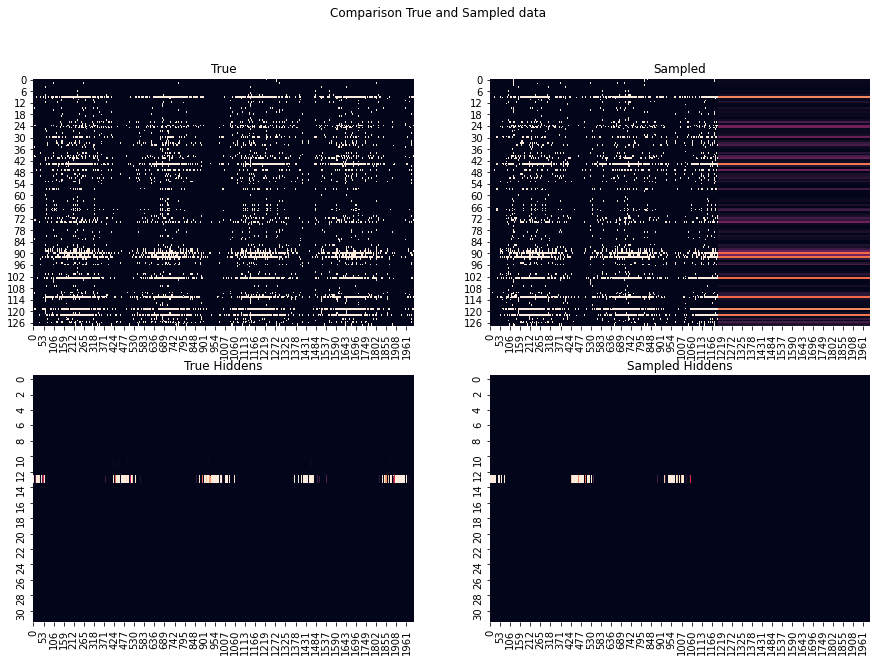

In [4]:
sample = 5
V_est, H_est = rtrbm.infer1(data[:,:1200], t_extra = 800, gibbs_k=200)


plot_true_sampled(data, rtrbm.rt, V_est, H_est)

In [5]:
v_prob = rtrbm.hidden_to_visible(rtrbm.rt)
print(v_prob.shape, v_prob[:,2])

torch.Size([128, 2000]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])


In [6]:
 t = 105
np.corrcoef(v_prob[:,t], v_prob[:,t+1])

array([[1.        , 0.29176188],
       [0.29176188, 1.        ]])

tensor(21.)

C:\Users\Sebastian\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Sebastian\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


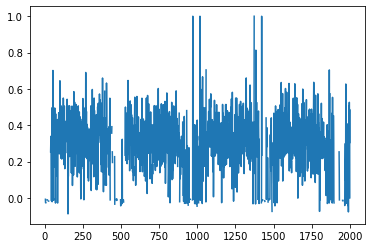

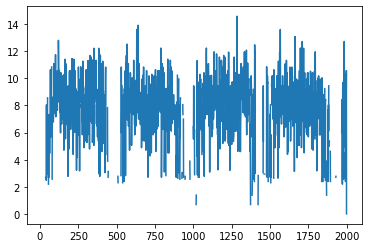

In [16]:
MU = torch.zeros(v_prob.shape[1])
corr = torch.zeros(v_prob.shape[1])
for t in range(v_prob.shape[1]-1):
    MU[t] = - torch.matmul(v_prob[:,t].T, v_prob[:,t+1]) * torch.log(torch.matmul(v_prob[:,t].T, v_prob[:,t+1]) / \
                                                                      (torch.sum(v_prob[:,t]) + torch.sum(v_prob[:,t+1])) )
    corr[t] = np.corrcoef(v_prob[:,t], v_prob[:,t+1])[0,1]
plt.plot(corr)
plt.show()
plt.plot(MU)

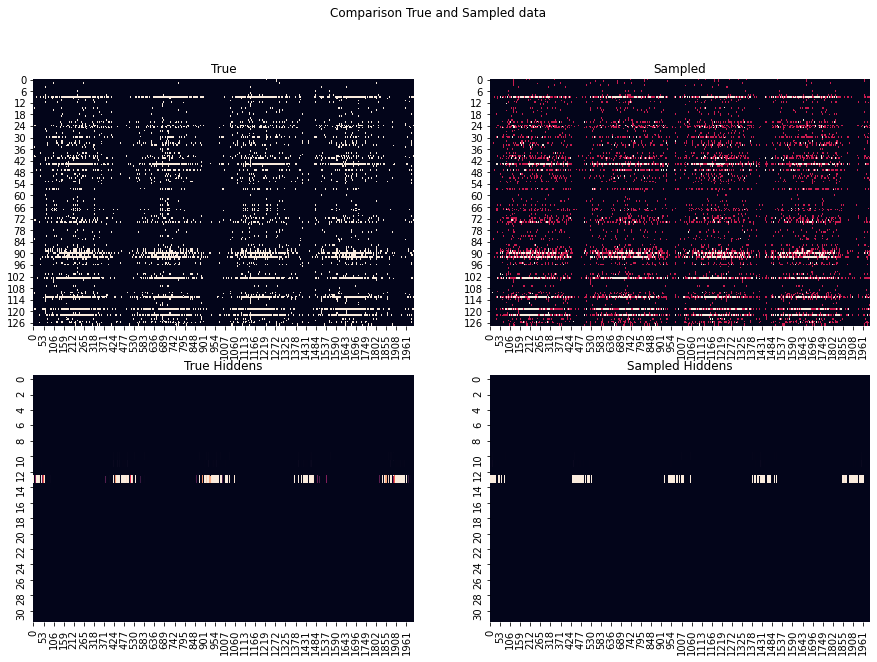

In [9]:
H_data_rtrbm = rtrbm.visible_to_hidden(data, T)
H_sampled_rtrbm = rtrbm.visible_to_hidden(rtrbm.v_infer, T)

plot_true_sampled(data, H_data_rtrbm, rtrbm.v_infer, H_sampled_rtrbm)

In [10]:
torch.mean(rtrbm.rt)


tensor(0.0070)

### Now for different sampling rate frequecies

For each different sampling frequenciy we sample n_batches = 128 batches, where one batch are the spike trains of N_V = 128 neurons for a duration of T = 1000 time steps. We compare the trained RTRBMs in their error, weight, weight distribution, bias and how good we can infer. This we will do while keeping torch.manual_seed(0) fixed.

In [11]:
sampling_frequency_range = [300, 100, 50, 30, 20, 15, 10, 5, 2]

# number of visible and hidden nodes, and timesteps
N_V = 128
N_H = 32
T = 2500
n_batches = 256

torch.manual_seed(0)
random.seed(0)

for i, sampling_frequency in enumerate(sampling_frequency_range)

    # generate mock data with time dependent firing
    data = torch.zeros([N_V, T, n_batches])
    for i in range(n_batches):
        data[:,:,i], _ = generate_mock_data(N_V, T, sampling_frequency=4, average_firing_rate=0.2, stimulus_period=50)
    
    # split data randomly in 7 train batches and 3 test batches
    #V_train, V_test = generate_train_test(data, train_data_ratio=0.7)
    
    # build RTRBM
    rtrbm = RTRBM(data)
    
    # train RTRBM
    rtrbm.learn(N_H,
          mean_field = 'False',
          activationFunction = torch.sigmoid,
          spars_penalty = 3e-5, x = 2, sp = False,
          learning_rate = 0.01, learning_rate_decay = True, 
          momentum = 0.9, 
          weightcost = 0.0002, 
          CDk = 10, 
          n_epochs = n_epochs, 
          batchsize = 64,
          disable_tqdm = False)
    
    # infer RTRBM 
    rtrbm.infer(data,
                activationFunction = torch.sigmoid,
                pre_gibbs_k = 50,
                gibbs_k = 10,
                mode = 2,
                t_extra = 0)

SyntaxError: invalid syntax (<ipython-input-11-9deba39e1586>, line 12)